# Aggregation



In [1]:
from pyrasterframes import rf_ipython
from docs import *
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
from pyspark.sql import *
import os

import numpy as np
np.set_printoptions(precision=3, floatmode='maxprec')

spark = create_rf_spark_session()


There are three types of aggregate functions available in RasterFrames: _tile_ aggregate, DataFrame aggregate, and element-wise local aggregate. In the @ref:[tile aggregate functions](reference.md#tile-statistics), we are computing a statistical summary per row of a _tile_ column in a DataFrame. In the @ref:[DataFrame aggregate functions](reference.md#aggregate-tile-statistics), we are computing statistical summaries over all of the cell values *and* across all of the rows in the DataFrame or group. In the @ref:[element-wise local aggregate functions](reference.md#tile-local-aggregate-statistics), we are computing the element-wise statistical summary across a DataFrame or group of _tiles_. In the latter two cases, when @ref:[vector data](vector-data.md) is the grouping column, the results are @ref:[zonal statistics](zonal-algebra.md).

## Tile Mean Example

We can illustrate aggregate differences by computing an aggregate mean. First, we create a sample DataFrame of 2 _tiles_. The _tiles_ will contain normally distributed cell values with the first row's mean at 1.0 and the second row's mean at 3.0. For details on use of the `Tile` class see @ref:[the page on numpy interoperability](numpy-pandas.md).



In [2]:
from pyrasterframes.rf_types import Tile, CellType

t1 = Tile(1 + 0.1 * np.random.randn(5,5), CellType('float64raw'))

t1.cells  # display the array in the Tile

array([[0.925, 1.165, 0.974, 1.143, 0.876],
       [0.967, 0.996, 1.133, 1.106, 0.969],
       [1.037, 1.014, 0.99 , 0.996, 1.071],
       [0.984, 1.006, 1.123, 1.042, 0.946],
       [0.839, 0.829, 1.175, 1.022, 0.891]])

In [3]:
t5 = Tile(5 + 0.1 * np.random.randn(5,5), CellType('float64raw'))
t5.cells

array([[5.031, 5.125, 4.815, 4.96 , 4.833],
       [4.981, 4.928, 5.025, 5.064, 5.049],
       [5.161, 4.88 , 4.964, 5.117, 4.904],
       [4.809, 4.978, 4.974, 4.937, 5.117],
       [5.046, 4.87 , 4.861, 4.99 , 4.966]])


Create a Spark DataFrame from the Tile objects.



In [4]:
import pyspark.sql.functions as F
from pyspark.sql import Row

rf = spark.createDataFrame([
    Row(id=1, tile=t1),
    Row(id=2, tile=t5)
]).orderBy('id')


We use the @ref:[`rf_tile_mean`](reference.md#rf-tile-mean) function to compute the _tile_ aggregate mean of cells in each row of column `tile`. The mean of each _tile_ is computed separately, so the first mean is about 1.0 and the second mean is about 3.0. Notice that the number of rows in the DataFrame is the same before and after the aggregation.



In [5]:
rf.select(F.col('id'), rf_tile_mean(F.col('tile')))

id,rf_tile_mean(tile)
1,1.0087786779521652
2,4.975462130333318



We use the @ref:[`rf_agg_mean`](reference.md#rf-agg-mean) function to compute the DataFrame aggregate, which averages values across the fifty cells in two rows. Note that only a single row is returned since the average is computed over the full DataFrame.



In [6]:
rf.agg(rf_agg_mean(F.col('tile')))

rf_agg_mean(tile)
2.9921204041427414



We use the @ref:[`rf_agg_local_mean`](reference.md#rf-agg-local-mean) function to compute the element-wise local aggregate mean across the two rows. For this aggregation, we are computing the mean of one value of 1.0 and one value of 3.0 to arrive at the element-wise mean, but doing so twenty-five times, one for each position in the _tile_.

To compute an element-wise local aggregate, _tiles_ need to have the same dimensions. In this case, both _tiles_ have 5 rows and 5 columns. If we tried to compute an element-wise local aggregate over the DataFrame without equal _tile_ dimensions, we would get a runtime error.



In [7]:
rf.agg(rf_agg_local_mean('tile')) \
    .first()[0].cells.data  # display the contents of the Tile array

array([[2.978, 3.145, 2.895, 3.052, 2.855],
       [2.974, 2.962, 3.079, 3.085, 3.009],
       [3.099, 2.947, 2.977, 3.056, 2.987],
       [2.896, 2.992, 3.049, 2.99 , 3.031],
       [2.942, 2.85 , 3.018, 3.006, 2.929]])


## Cell Counts Example

We can also count the total number of data and NoData cells over all the _tiles_ in a DataFrame using @ref:[`rf_agg_data_cells`](reference.md#rf-agg-data-cells) and @ref:[`rf_agg_no_data_cells`](reference.md#rf-agg-no-data-cells). There are ~3.8 million data cells and ~1.9 million NoData cells in this DataFrame. See the section on @ref:["NoData" handling](nodata-handling.md) for additional discussion on handling missing data.



In [8]:
rf = spark.read.raster('https://s22s-test-geotiffs.s3.amazonaws.com/MCD43A4.006/11/05/2018233/MCD43A4.A2018233.h11v05.006.2018242035530_B02.TIF')
stats = rf.agg(rf_agg_data_cells('proj_raster'), rf_agg_no_data_cells('proj_raster'))
stats

rf_agg_data_cells(proj_raster),rf_agg_no_data_cells(proj_raster)
3825959,1934041



## Statistical Summaries

The statistical summary functions return a summary of cell values: number of data cells, number of NoData cells, minimum, maximum, mean, and variance, which can be computed as a _tile_ aggregate, a DataFrame aggregate, or an element-wise local aggregate.

The @ref:[`rf_tile_stats`](reference.md#rf-tile-stats) function computes summary statistics separately for each row in a _tile_ column as shown below.



In [9]:
rf = spark.read.raster('https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B02.tif')
stats = rf.select(rf_tile_stats('proj_raster').alias('stats'))

stats.printSchema()

root
 |-- stats: struct (nullable = true)
 |    |-- data_cells: long (nullable = false)
 |    |-- no_data_cells: long (nullable = false)
 |    |-- min: double (nullable = false)
 |    |-- max: double (nullable = false)
 |    |-- mean: double (nullable = false)
 |    |-- variance: double (nullable = false)



In [10]:
stats.select('stats.min', 'stats.max', 'stats.mean', 'stats.variance')

min,max,mean,variance
199.0,5331.0,455.5312957763667,68728.44405841625
187.0,1911.0,310.51860046386815,13849.46165963797
181.0,1530.0,259.9732513427734,3501.4270036255507
170.0,2535.0,292.7441253662109,11137.773410618069
152.0,3641.0,290.0180511474609,14295.314752891418



The @ref:[`rf_agg_stats`](reference.md#rf-agg-stats) function aggregates over all of the _tiles_ in a DataFrame and returns a statistical summary of all cell values as shown below.



In [11]:
stats = rf.agg(rf_agg_stats('proj_raster').alias('stats')) \
    .select('stats.min', 'stats.max', 'stats.mean', 'stats.variance')
stats

min,max,mean,variance
3.0,12103.0,542.1327946489893,685615.201702677



The @ref:[`rf_agg_local_stats`](reference.md#rf-agg-local-stats) function computes the element-wise local aggregate statistical summary as shown below. The DataFrame used in the previous two code blocks has unequal _tile_ dimensions, so a different DataFrame is used in this code block to avoid a runtime error.



In [12]:
rf = spark.createDataFrame([
    Row(id=1, tile=t1),
    Row(id=3, tile=t1 * 3),
    Row(id=5, tile=t1 * 5)
]).agg(rf_agg_local_stats('tile').alias('stats'))
    
agg_local_stats = rf.select('stats.min', 'stats.max', 'stats.mean', 'stats.variance').collect()

for r in agg_local_stats:
    for stat in r.asDict():
        print(stat, ':\n', r[stat], '\n')

min :
 Tile(dimensions=[5, 5], cell_type=CellType(float64, nan), cells=
[[0.9251059167204836 1.1652529308025203 0.9744028516572834
  1.1434357998843876 0.876003339684339]
 [0.9674666845915747 0.9958565366981841 1.133051188347305
  1.1056253177461717 0.9685396187117463]
 [1.0367020259586313 1.0141486340600443 0.9899931290774389
  0.9958924711871238 1.0707076686301173]
 [0.9838836750490918 1.0063558345483652 1.1232385156452924
  1.04160988997014 0.9457853905289378]
 [0.8387028717706597 0.8289668703445426 1.1753055697976789
  1.0222727198211095 0.8911614975709614]]) 

max :
 Tile(dimensions=[5, 5], cell_type=CellType(float64, nan), cells=
[[4.625529583602418 5.8262646540126015 4.872014258286416
  5.717178999421938 4.380016698421695]
 [4.837333422957873 4.97928268349092 5.6652559417365245 5.528126588730858
  4.842698093558732]
 [5.183510129793156 5.070743170300221 4.949965645387194 4.979462355935619
  5.3535383431505865]
 [4.919418375245459 5.031779172741826 5.616192578226462 5.20804944985


## Histogram

The @ref:[`rf_tile_histogram`](reference.md#rf-tile-histogram) function computes a count of cell values within each row of _tile_ and outputs a `bins` array with the schema below. In the graph below, we have plotted each bin's `value` on the x-axis and `count` on the y-axis for the _tile_ in the first row of the DataFrame.




root
 |-- bins: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- value: double (nullable = false)
 |    |    |-- count: long (nullable = false)



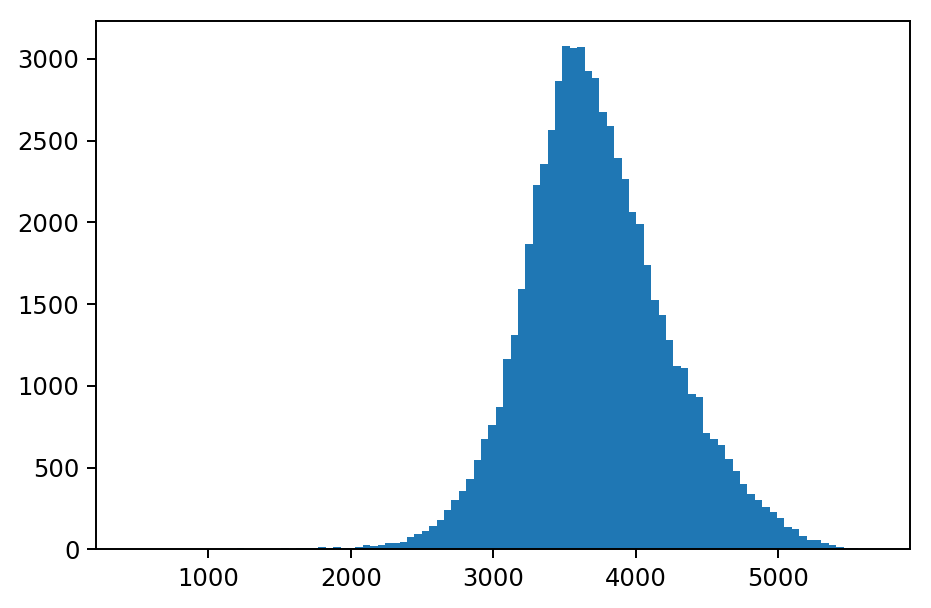

In [13]:
import matplotlib.pyplot as plt

rf = spark.read.raster('https://s22s-test-geotiffs.s3.amazonaws.com/MCD43A4.006/11/05/2018233/MCD43A4.A2018233.h11v05.006.2018242035530_B02.TIF')

hist_df = rf.select(rf_tile_histogram('proj_raster')['bins'].alias('bins'))
hist_df.printSchema()

bins_row = hist_df.first()
values = [int(bin['value']) for bin in bins_row.bins]
counts = [int(bin['count']) for bin in bins_row.bins]

plt.hist(values, weights=counts, bins=100)
plt.show()


The @ref:[`rf_agg_approx_histogram`](reference.md#rf-agg-approx-histogram) function computes a count of cell values across all of the rows of _tile_ in a DataFrame or group. In the example below, the range of the y-axis is significantly wider than the range of the y-axis on the previous histogram since this histogram was computed for all cell values in the DataFrame.




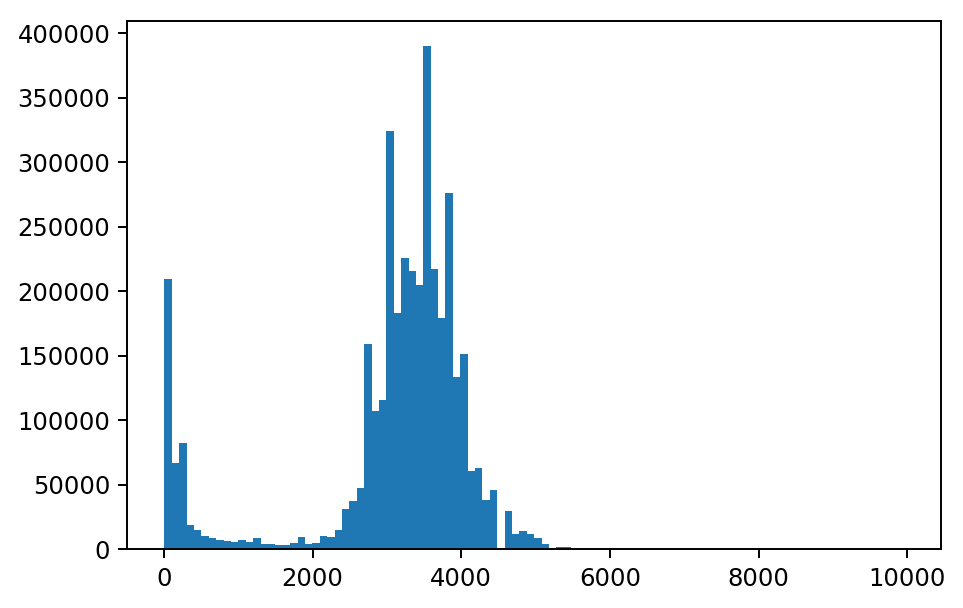

In [14]:
bins_list = rf.agg(
    rf_agg_approx_histogram('proj_raster')['bins'].alias('bins')
    ).collect()
values = [int(row['value']) for row in bins_list[0].bins]
counts = [int(row['count']) for row in bins_list[0].bins]

plt.hist(values, weights=counts, bins=100)
plt.show()